In [5]:
from IPython.display import YouTubeVideo

# MSE 8900 / CHE 8450 - Multiscale Modeling

Rachel B. Getman, Sapna Sarupria, Ulf D. Schiller

Clemson University

## Lecture 3.3: Dissipative Particle Dynamics

1. Numerical integration of stochastic differential equations
2. Fokker-Planck equation
3. Disspative Particle Dynamics

### References

1. M. P. Allen and D. J. Tildesley, Computer Simulation of Liquids, 2nd edition, Oxford University Press, Oxford, 2017  
(Chapters 12.2-4)
2. D. Frenkel and B. Smit, Understanding Molecular Simulation: From Algorithms to Applications, 2nd edition, Academic Press, San Diego 2002  
(Chapters 4, 17)
3. N. G. van Kampen, Stochastic Processes in Physics and Chemistry, 3rd edition, Elsevier, Amsterdam 2007  
(Chapters 8, 9)
4. J.-P. Hansen, I. R. McDonald, Theory of Simple Liquids with Applications to Soft Matter, 4th edition, Academic Press, Oxford 2013  
(Chapters 7, 8)

### Numerical Integration of Stochastic Differential Equations

* Recall the Langevin equation (now including a force $F$)
$$m dv = F(t) dt - m \gamma v(t) dt + \sqrt{2 m \gamma k_B T} \ \eta(t) dt$$
* Integrate over a time step $h$
$$m v(t+h) = mv(t) + \int_{t}^{t+h} F(t') dt' - m \gamma \int_{t}^{t+h} v(t') dt' + \sqrt{2 m \gamma k_B T} \int_{t}^{t+h} \eta(t') dt'$$
* Represent the noise by a _Wiener process_
$$ \eta(t) = \frac{dW}{dt} $$
* Correlations of the Wiener process
$$\begin{aligned}
\langle W(t) W(t') \rangle &= \int_0^t dt_1 \int_0^{t'} dt_2 \langle \eta(t_1)\eta(t_2) \rangle = \min(t,t') \\
\langle (W(t+h) - W(t))^2 \rangle &= h
\end{aligned}$$
* Wiener increment is an $O(\sqrt{h})$ infinitesimal ($\xi$ is Gaussian random number with zero mean and unit variance)
$$ W(t+h) - W(t) = \sqrt{h} \xi(t)$$
* First order approximation (_Euler-Maruyama method_)
$$ m v(t+h) = mv(t) + F(t) h - m \gamma v(t) h + \sqrt{2 m \gamma k_B T h} \xi(t) $$
* Compare to exact solution
$$\begin{aligned} v(t+h) &= v(t) \exp(-\gamma h) + \frac{1}{m} \exp(-\gamma h) \int_{t}^{t+h} \left[F(t')+\sqrt{2 m \gamma k_B T} \eta(t')\right] \exp(\gamma t') dt' \\
v(t+h)-\overline{v(t+h)} &= \frac{1}{m} \int_{t}^{t+h} \eta(t') \exp(-\gamma(h-t') dt' \\
\overline{\left(v(t+h)-\overline{v(t+h)}\right)^2} &= \frac{k_B T}{m} \left( 1 - \exp(-2\gamma h) \right)
\end{aligned}$$
* Exact update (constant $F$)
$$\begin{aligned}
v(t+h) &= v(t) \exp(-\gamma h) + \frac{F}{m\gamma} \left(1-\exp(-\gamma h)\right) + \sqrt{\frac{k_BT}{m}\left(1-\exp(-2\gamma h)\right)} \xi(t) \\
&\approx v(t) - \gamma v(t) h + \frac{F}{m} h + \frac{1}{m} \sqrt{2 m \gamma k_B T h} \xi(t)
\end{aligned}$$
* Error in trajectories (_strong convergence_) $O(\sqrt{h})$
* Error in expectation values (_weak convergence_) $O(h)$

### Langevin Dynamics (Ornstein-Uhlenbeck Process)

In [ ]:
import numpy as np
import matplotlib.pyplot as p

n_runs = 5
t_init = 0
t_end  = 10
N      = 1000
dt     = float(t_end - t_init) / N 

v0     = 0

kT    = 1.0
gamma = 1.0
force = 10.0
sigma = np.sqrt(2*gamma*kT)

def dW(delta_t): 
    """Sample a random number at each call."""
    return np.random.normal(loc = 0.0, scale = np.sqrt(delta_t))

ts    = np.arange(t_init, t_end, dt)
vs    = np.zeros(N)

vs[0] = v0

for _ in range(n_runs):
    for i in range(0, ts.size-1):
        v = vs[i]
        vs[i+1] = v + force*dt - gamma*v*dt + sigma*dW(dt)
    p.plot(ts, vs)

p.show()

### Overdamped Langevin Dynamics (Brownian Dynamics)

* in the high friction limit, inertia becomes negligible
* overdamped Langevin equation
$$ \dot{x} = \frac{1}{m\gamma} \left( F + \eta \right) = \frac{D}{k_B T} \left( F + \eta \right) $$
* First order approximation
$$ x(t+h) = x(t) + \frac{D}{k_B T} F h + \sqrt{2 D h} \xi(t) $$
* in general $D$ is a tensor $D_{ij}$ (depending on positions of all particles)
* Oseen tensor

$${D}_{ij}(\vec{r}) = \frac{k_B T}{8 \pi \eta \, {r}} \left( \mathsf{I} + \frac{\vec{r} \otimes \vec{r}}{r^2} \right)$$

<!--
* Rotne-Prager tensor

$$\begin{aligned}\label{eq:rotne-prager}
{D}_{ij} &= D_0\; \Bigg\{\left(1-\frac{9\,r_{ij}}{32\,a}\right) \mathbf{I} + \frac{3}{32} \frac{\mathbf{r}_{ij} \otimes \mathbf{r}_{ij}}{a\,r_{ij}}\Bigg\}, &\quad r_{ij} < 2a\nonumber\\
{D}_{ij} &=\nonumber
D_0\; \frac{3\,a}{4\,r_{ij}}\;\Bigg\{\mathbf{I} + \frac{\mathbf{r}_{ij} \otimes \mathbf{r}_{ij}}{r^2_{ij}} \\ &\qquad\qquad\qquad+ \frac{2\,a^2}{3\,r^2_{ij}} \left(\mathbf{I} - 3 \frac{\mathbf{r}_{ij} \otimes \mathbf{r}_{ij}}{r^2_{ij}}\right)\Bigg\}, &\quad r_{ij}\ge 2a\nonumber\\
{D}_{ii} &= D_0\; \mathbf{I}
\end{aligned}$$
-->

* overdamped limit of Langevin Dynamics

$$ \dot{\vec{r}}_i = \sum_j \frac{D_{ij}}{k_B T} F_j + \Delta\vec{r}_i $$

* Fluctuation dissipation relations

$$\begin{aligned}
\left\langle \Delta\vec{r}_i \right\rangle &= 0 , \\
\left\langle \Delta\vec{r}_i(t) \Delta\vec{r}_j(t') \right\rangle &= 2 \mathsf{D}_{ij} \delta(t-t') .
\end{aligned}$$

* Time-integration with $\mathsf{D}_{ij} = \mathsf{B}_{ik}\cdot\mathsf{B}^T_{jk}$

$$\vec{r}_i(t+h) = \vec{r}_i(t) + \frac{\mathsf{D}_{ij}}{k_BT} h \vec{F}_j + \sqrt{2 h} \, \mathsf{B}_{ij} \cdot \vec{W}_j $$

* Wiener process $\left\langle \vec{W}_i \right\rangle = 0$ and $\left\langle \vec{W}_i \otimes \vec{W}_j \right\rangle = \mathbf{I} \delta_{ij}$. 

* Cholesky decomposition $O(N^3)$

$$\mathsf{D}_{ij}=\mathsf{C}_{ik}\cdot\mathsf{C}^T_{jk}$$ 

* Chebyshev polynomial approximation $O(N^{2.25})$

* Ewald-like methods using fast Fourier transformations $O(n^{1+x}\log N)$

### Brownian Dynamics

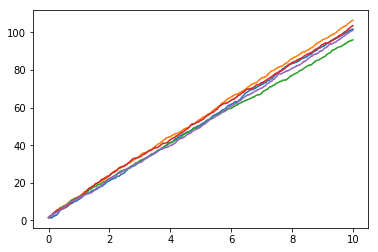

In [22]:
import numpy as np
import matplotlib.pyplot as p

n_runs = 5
t_init = 0
t_end  = 10
N      = 1000
dt     = float(t_end - t_init) / N 

x0     = 1.5

kT    = 0.1
D     = 0.5
force = 2.0
sigma = np.sqrt(2*D)

def dW(delta_t): 
    """Sample a random number at each call."""
    return np.random.normal(loc = 0.0, scale = np.sqrt(delta_t))

ts    = np.arange(t_init, t_end, dt)
xs    = np.zeros(N)

xs[0] = x0

for _ in range(n_runs):
    for i in range(0, ts.size-1):
        x = xs[i]
        xs[i+1] = x + D/kT*force*dt + sigma*dW(dt)
    p.plot(ts, xs)

p.show()

### Fokker-Planck Equations

The discussion of Langevin dynamics so far begs to questions:
1. How do we know that we sample the correct equilibrium distribution (canonical ensemble)?
2. How does the probability distribution evolve under the stochastic dynamics?

#### Moment Expansion of the PDF

* Define moments of the PDF
$$ \mu_n = \int x^n p(x) \mathrm{d}x $$
* Consider Fourier transform
$$ p(k) = \int p(x) \exp(ikx) \mathrm{d}x = \sum_{n=0}^\infty \frac{(ik)^n}{n!} \mu_n$$
* $p(x)$ is _uniquely_ determined by its moments
$$ p(x) = \sum_{n=0}^\infty \frac{(-1)^n}{n!} \frac{\partial^n}{\partial x^n} \delta(x) \mu_n $$
* Consider _conditional_ PDF
$$ p(x,t|x_0,t_0) = \sum_{n=0}^\infty \frac{(-1)^n}{n!} \frac{\partial^n}{\partial x^n} \delta(x-x_0) \mu_n(t|x_0,t_0) $$
* $\mu_n(t|x_0,t_0)$ are the mean displacement, mean square displacement, etc.
* Chapman-Kolmogorov
$$\begin{aligned} 
p(x,t|x_0,t_0) &= \int \mathrm{d}x_1 p(x,t|x_1,t-h)p(x_1,t-h|x_0,t_0) \\
&= \sum_{n=0}^\infty \frac{(-1)^n}{n!} \frac{\partial^n}{\partial x^n} \mu_n(t|x,t-h)P(x,t-h|x_0,t_0)
\end{aligned}$$
* Subtract $n=0$ term
$$P(x,t|x_0,t_0)-P(x,t-h|x_0,t_0) = \sum_{n=1}^\infty \frac{(-1)^n}{n!} \frac{\partial^n}{\partial x^n} \mu_n(t|x,t-h)P(x,t-h|x_0,t_0) $$

#### Kramers-Moyal expansion

* Short time behavior of the moments given by
$$ \mu_n(t|x,t-h) = n! D^{(n)}(x,t-h) h + o(\tau) \approx n! D^{(n)}(x,t) h $$
* Inserting into the moment expansion leads to the _generalized Fokker-Planck equation_
$$ \frac{\partial}{\partial t} p(x,t|x_0,t_0) = \sum_{n=1}^\infty (-1)^n \frac{\partial^n}{\partial x^n} \left[ D^{(n)}(x,t)P(x,t|x_0,t_0) \right] = \mathcal{L} p(x,t|x_0,t_0)$$
* Shorthand notation: _Fokker-Planck operator_ $\mathcal{L}$
* _Pawula theorem_: the expansion stops at $n=0$, $n=1$, $n=2$ or $n=\infty$
* There are only four types of processes
* Consider a diffusive process ($D^{(1)}$: drift, $D^{(2)}$: diffusion)
$$\begin{aligned}
\langle \Delta x_i \rangle &= D_i^{(1)}(x,t) h + \dots \\
\left\langle \Delta x_i \Delta x_j \right\rangle &= 2 D_{ij}^{(2)}(x,t) h + \dots
\end{aligned}$$
* Process can be generated by the dynamics
$$\begin{aligned}
x_i(t+h) &= x_i(t) + D_i^{(1)} h + \sqrt{2 D^{(2)}_{ij} h} \xi_i(t) \\
dx_i &= D_i^{(1)} dt + \sqrt{2 D_{ij}^{(2)}} dW_{ij}(t)
\end{aligned}$$

### Stochastic Dynamics

* Augment Hamilton's equations of motion by friction and noise terms
$$\begin{aligned}
\dot{q}_i &= \frac{\partial\mathcal{H}}{\partial p_i} \\
\dot{p}_i &= - \frac{\partial\mathcal{H}}{\partial q_i} - \gamma_i \frac{\partial\mathcal{H}}{\partial p_i} + \sqrt{\Gamma_i} \eta_i
\end{aligned}$$
* Fokker-Planck operator $\mathcal{L}=\mathcal{L}_{\mathcal{H}} + \mathcal{L}_\text{SD}$ ($\mathcal{L}_\mathcal{H}$ corresponds to Liouville operator)
$$ \mathcal{L}_\text{SD} = \sum_i \frac{\partial}{\partial p_i} \left[ \gamma_i \frac{\partial\mathcal{H}}{\partial p_i} + \frac{\Gamma_i}{2} \frac{\partial}{\partial p_i} \right]$$
* Stationarity of the equilibrium distribution requires
$$\mathcal{L}_\text{SD} \exp(-\beta\mathcal{H}) = \sum_i \frac{\partial}{\partial p_i} \left[\gamma_i \frac{\partial\mathcal{H}}{\partial p_i} - \beta\frac{\Gamma_i}{2} \frac{\partial\mathcal{H}}{\partial p_i} \right] \exp(-\beta\mathcal{H}) = 0$$
* Fluctuation-Dissipation relation
$$ \Gamma_i = 2 \gamma_i k_B T $$

### Connection between SD, MD, MC

* Brownian Dynamics
$$ r(t+h) = r(t) + \frac{D}{k_BT} F(t) h + \sqrt{2Dh} \xi(t) $$
* Molecular Dynamics
$$ r(t+h) = r(t) + v(t) h + \frac{h^2}{2m} F(t) $$
* the two can be mapped by substituting $D=\frac{k_BT}{2m} h$
* implies a Maxwell-Boltzmann distributed random velocity (cf. Andersen thermostat)
$$\begin{aligned}
v(t) &= \frac{k_BT}{m} \xi(t) \\
v(t+h) &= v(t) + \frac{F(t)+F(t+h)}{2m}
\end{aligned}$$
* can be used as trial move with acceptance rate (Metropolis-MC)
$$ p_\text{accept} = \min(1,\exp(-\beta\Delta U)\exp(-\beta\Delta K))=\min(1,\exp(-\beta\mathcal{H}) $$

### Dissipative Particle Dynamics

![Dissipative Particle Dynamics](assets/fluid_particles.png)

### Disspative Particle Dynamics

* Idea:
    * pairwise interactions
    * friction applied to relative velocity
    * satisfy Newton's third law
    * allow cut-off of interactions

* In Practice: Three forces
    * Conservative force $$\vec{F}^C_{ij} = - \nabla U(r_{ij})$$
    * Disspative force $$\vec{F}^D_{ij} = - \gamma(r_{ij}) ( \vec{v}_{ij} \hat{r}_{ij})\hat{r}_{ij}$$
    * Random force $$\vec{F}^R_{ij} = \sigma(r_{ij}) \eta_{ij} \hat{r}_{ij}$$
    
* Traditional choice: soft conservative interactions
$$ \vec{F}^C_{ij} = \begin{cases} a_{ij} (1-r_{ij})\hat{r}_{ij} & r_{ij} < r_c \\
0 & r_{ij} \ge r_c \end{cases} $$

* Properties of the random noise
$$\begin{aligned}
\langle \eta_{ij} \rangle &= 0 \\
\langle \eta_{ij}(t) \eta_{i'j'}(t') \rangle &= \left( \delta_{ii'}\delta_{jj'} + \delta_{ij'}\delta_{i'j} \right) \delta(t-t')
\end{aligned}$$

### Fokker-Planck operator for DPD

* Stochastic differential equation for DPD
$$\begin{aligned}
d\vec{r}_i &= \vec{v}_i dt \\
d\vec{p}_i &= \sum_j \left[ \vec{F}^C_{ij} dt - \gamma(r_{ij}) \left(\vec{v}_{ij}\cdot\hat{r}_{ij}\right)\hat{r}_{ij} dt + \sigma(r_{ij}) \hat{r}_{ij} dW_{ij} \right]
\end{aligned}$$

* Fokker-Planck operator
    * conservative part
    $$\mathcal{L}_C=-\sum_i \frac{\vec{p}_i}{m_i}\frac{\partial}{\partial \vec{r}_i} - \sum_{j\ne i} \vec{F}^C_{ij}\frac{\partial}{\partial p_i}$$
    * friction part
    $$\mathcal{L}_D=\sum_{j\ne i} \gamma(r_{ij}) \left( \hat{r}_{ij} \frac{\partial}{\partial p_i}\right) \left[ \hat{r}_{ij} \left(\frac{\partial\mathcal{H}}{\partial \vec{p}_i} - \frac{\partial\mathcal{H}}{\partial\vec{p}_j}\right)\right]$$
    * random part
    $$\begin{aligned}
    \mathcal{L}_R&=\sum_{j\ne i} \frac{\sigma^2(r_{ij})}{2} \left[ \left(\hat{r}_{ij}\frac{\partial}{\partial \vec{p}_i}\right)^2 - \left(\hat{r}_{ij}\frac{\partial}{\partial \vec{p}_i}\right)\left(\hat{r}_{ij}\frac{\partial}{\partial \vec{p}_j} \right) \right]\\
    &= \sum_{j\ne i} \frac{\sigma^2(r_{ij})}{2} \left(\hat{r}_{ij}\frac{\partial}{\partial \vec{p}_i}\right) \left[ \hat{r}_{ij} \left( \frac{\partial}{\partial \vec{p}_i} - \frac{\partial}{\partial \vec{p}_j} \right) \right]
    \end{aligned}$$
* Fluctuation-Disspation relation for DPD
$$\sigma^2(r_{ij}) = 2 \gamma(r_{ij}) k_B T$$
* commonly satisfied through
$$\begin{aligned}
\sigma^2 &= 2\gamma k_B T \\
w_D(r) &= w_R^2(r) = w(r)
\end{aligned}$$

* Weighting function
$$w(r) = \begin{cases} 1-\frac{r}{r_c} & r<r_c \\
0 & r \ge r_c \end{cases}$$

![Weighting Function](assets/wf.png)

### DPD for Complex Fluids
* Example: Colloid in a DPD solvent
![Colloid in DPD](assets/dpd-sphere.png)

### Parameters and Properties of DPD

* Matching the compressibility and viscosity of water under ambient condition [Groot & Warren 1997]

\begin{equation*}
\kappa^{-1} = \frac{1}{k_B T}{\frac{\partial p}{\partial \rho}} = \frac{1}{k_BT}{\frac{\partial p}{\partial n}}\frac{\partial n}{\partial \rho}
\end{equation*}

$$\begin{aligned}
\rho&=3 & \sigma&=3 & k_BT&=1
\end{aligned}$$

* for the standard soft potential $\alpha \sim 0.101 a r_c^4$

\begin{equation*}
\text{water:}\ \kappa^{-1} \sim 16 \qquad \Rightarrow \qquad a \sim 75 \frac{k_BT}{\rho r_c^4}
\end{equation*}

* Equation of state at high density

\begin{equation*}
p = \rho k_BT + \alpha \rho^2
\end{equation*}

* Caveat: the DPD fluid will freeze if $\rho$ is too high or $k_BT$ too low

* DPD satisfies an $H$-theorem (i.e., equilibration is guaranteed)

* Characteristic relaxation rate

\begin{equation*}
\omega_0 = \frac{n \gamma \left[ w \right]}{d}
\qquad\qquad 
\left[ w \right] = \int w(r) d\vec{r}
\qquad\qquad d\ \text{dimensions}
\end{equation*}


#### Model Parameters

| | | |
|---|---|---|
| $m$             | mass of DPD particles                     | |
| $r_c$           | range of DPD interactions (cutoff radius) | |
| $\gamma$        | friction coefficient                      | |
| $\sigma$        | noise amplitude                           | |
| $L$             | size of simulation box                    | $V=L^d$ |
| $N$             | number of particles                       | |

#### Derived Parameters

||||
|---|---|---|
| $T_0$           | equilibrium temperature                   | $T_0=mv_0^2=m\sigma^2/2\gamma$ |
| $n$             | number density                            | $n=N/L^d$ |
| $n_c$           | number of particles in interaction sphere | $n_c=n(\sigma_dr_c^d)$ |
| $t_c$           | traversal time of interaction sphere      | $t_c=r_c/v_0$ |
| $\omega_0$      | collision frequency                       | $\omega_0=\frac{1}{d}n[w]\gamma\propto n_c\gamma$ |
| $t_0$           | collision time                            | $t_0=1/\omega_0$ |
| $l_0$           | dynamic distance (mean free path)         | $l_0=v_0t_0$ |
| $t_\gamma$      | friction time                             | $t_\gamma=1/n[w]\gamma=t_0/d$ |
| $l_\gamma$      | dynamic friction distance                 | $l_\gamma=v_0t_\gamma=l_0/d$ |

#### Dimensionless Parameters ($n[w]=1$)

||||
|---|---|---|
| $\Omega_0$      | dynamic overlapping                       | $\Omega_0=r_c/l_0$ |
| $\Omega_\gamma$ | dynamic friction overlapping              | $\Omega_\gamma=dr_c/l_\gamma=d/n_c\Omega_0$ |
| $\Omega_L$      | dimensionless box length                  | $\Omega_L=r_c/L$ |
| $\Omega_s$      | dimensionless density                     | $\Omega_s=r_c/l_s$ |

### Transport Properties of DPD

* Viscosities: kinetic and dissipative contributions [Marsh, Backx and Ernst 1997]

$$\begin{aligned}
\eta_K&=\frac{nk_BT}{2\omega_0} &\qquad 
\zeta_K&=\frac{nk_BT}{d\omega_0} \\
\eta_D&=\frac{\gamma m n^2 \langle R^2 \rangle_w \left[w\right]}{2d(d+2)} &\qquad 
\zeta_D&=\frac{\gamma m n^2 \langle R^2 \rangle_w \left[w\right]}{2d^2}
\end{aligned}$$

\begin{equation*}
\left\langle R^2 \right\rangle_w = \frac{\left[ R^2 w \right]}{[w]}
\end{equation*}

* tuning of the solvent properties is a little cumbersome

### Dynamic Regimes of DPD

![](assets/dpd-omega.png)

### Dynamic Regimes of DPD

| | low density | high density |
|---|---|---|
|low friction  | _collective collisions_  | _mixed collisions_             |
|              |  FPB (MBE theory)        | kinetic theory (MBE/Boltzmann) |
| high friction | _binary collisions_  | _collective collisions_ |
|               | Boltzmann theory     | ?                       |

![](assets/operators.png)

### Schmidt number in DPD

* momentum transport vs. mass transport
$$Sc = \frac{\nu}{D}$$

* in real fluids the Schmidt number is on the order of $Sc \sim 10^2-10^3$

* rom transport properties of DPD [Groot and Warren 1997]

\begin{equation*}
Sc \approx \frac{1}{2} + \frac{(2 \pi \gamma \rho r_c^4)^2}{70875k_BT}
\end{equation*}

* DPD: $Sc=O(1)$ $\rightarrow$ particles are diffusing as fast as momentum

* Oseen approximation breaks down (problematic e.g. for polymer solutions)

* consequence of soft potential (partly remedied by dissipative and random forces)

* Lowe-Anderson thermostat shows better behavior

### Lowe-Andersen thermostat

* Idea: with a probability $\gamma h$ replace the relative velocity with a new velocity drawn from a Maxwell-Boltzmann distribution

$$ \vec{v}'_{ij}\hat{r}_{ij} = \sqrt{\frac{2k_BT}{m}} \xi_{ij} $$

* new velocities of the particles

$$ \begin{aligned}
\vec{v}'_i&=\vec{v}_i+\vec{\Delta}_{ij} \\
\vec{v}'_j&=\vec{v}_j-\vec{\Delta}_{ij} \\
2\vec{\Delta}_{ij} &= \hat{r}_{ij}\left(\vec{v}'_{ij}-\vec{v}_{ij}\right)\hat{r}_{ij}
\end{aligned}$$

* conserves momentum, Galilei invariant

* is a valid canonical Monte Carlo procedure (cf. Andersen thermostat)

* contribution to shear viscosity

$$ \eta_D=\frac{\pi \rho^2 \gamma r_c^5}{75m} $$

### DPD and finite time steps

* the dissipative force $\vec{F}^D$ is velocity dependent

* Velocity-Verlet integration is not symplectic any more!

* consequence: equilibrium properties become inaccurate
  (temperature, radial distribution function,...)
$$k_B T_{\Delta t} = \frac{A_3}{A_1(2-A_1n\Delta t) - A_2 \Delta t}$$

\begin{align*}
A_1&=\frac{\gamma}{3m}[w] 
&A_2&=\frac{2\gamma^2}{3m^2}[w^2]
&A_3&=\frac{\sigma^2}{3m}[w^2]
\end{align*}

* need higher order integrators

### Energy conserving DPD

* Energy is not conserved in standard DPD
* Temperature gradients cannot be sustained
* Introduce an internal energy $\epsilon_i$ for each particle
* Equation of motion
$$d\epsilon_i = \sum_j k_{ij} \left(\frac{1}{T_i}-\frac{1}{T_j}\right) w(r_{ij}) dt + \sum_j \xi^T_{ij}$$
$$d\epsilon_i = \frac{m_i}{2} \sum_j \left[ \gamma w^D(r_{ij}) \left(\vec{v}_{ij}\hat{r}_{ij}\right)^2-\sigma^2 (w^R(r_{ij}))^2\right] dt - \sum_j \sigma w^R(r_{ij}) (\vec{v}_{ij}\hat{r}_{ij}) d\xi_{ij}$$

### Hands-On Activity

1. Test the strong and weak convergence properties of the Euler-Maruyama method (using Langevin dynamics or Brownian dynamics).
2. Implement a DPD thermostat in your MD code and investigate its properties (energy, viscosity, diffusion).
3. Investigate the decay of the VACF using DPD.

### References

1. P. J. Hoogerbrugge and J. M. V. A. Koelman, Simulating Microscopic Hydrodynamic Phenomena with Dissipative Particle Dynamics. Europhys. Lett. 19, 155–160 (1992).
2. P. Español and P. Warren, Statistical Mechanics of Dissipative Particle Dynamics. Europhys. Lett. 30, 191–196 (1995).
2. C. P. Lowe, An alternative approach to disspative particle dynamics. Europhys. Lett. 47, 145-151 (1999).
1. P. Español and P. B. Warren, Perspective: Dissipative particle dynamics. J. Chem. Phys 146, 150901 (2017).
5. U. D. Schiller et al., Mesoscopic modelling and simulation of soft matter. Soft Matter 14, 9–26 (2017).
